In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.color import label2rgb
import scipy 

from torch.utils.data import DataLoader
import torch.nn.functional as F

from gelgenie.segmentation.networks.UNets.model_gateway import smp_UNetPlusPlus
from gelgenie.segmentation.data_handling.dataloaders import ImageDataset

import torch
from scipy import ndimage as ndi

In [6]:
image_file = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/gelgenie/data_analysis/ref_data/ladder_reference_gel.tif'

raw_im = np.array(Image.open(image_file).convert('L'))

In [ ]:
def load_model(checkpoint):
    net = smp_UNetPlusPlus(
                encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=2,  # model output channels (number of classes in your dataset)
            )
    net.eval()
    saved_dict = torch.load(f=checkpoint, map_location=torch.device("cpu"))
    net.load_state_dict(saved_dict['network'])
    print(f'Model loaded from {checkpoint}')
    return net

# prepping model
checkpoint_file_path = "/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp_unet++_july28_1/checkpoints/checkpoint_epoch_306.pth"

net = load_model(checkpoint_file_path)

image_dir = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/gelgenie/data_analysis/ref_data'
val_set = ImageDataset(image_dir, 1, padding=True)

dataloader = DataLoader(val_set, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)

# segmentation map generation
net.eval()
for im_index, batch in enumerate(dataloader):
    with torch.no_grad():
        mask_pred = net(batch['image'])
        break

size_adjusted_im = batch['image'].squeeze().detach().squeeze().cpu().numpy()
        

In [100]:
segmentation_mask.shape

(2, 800, 600)

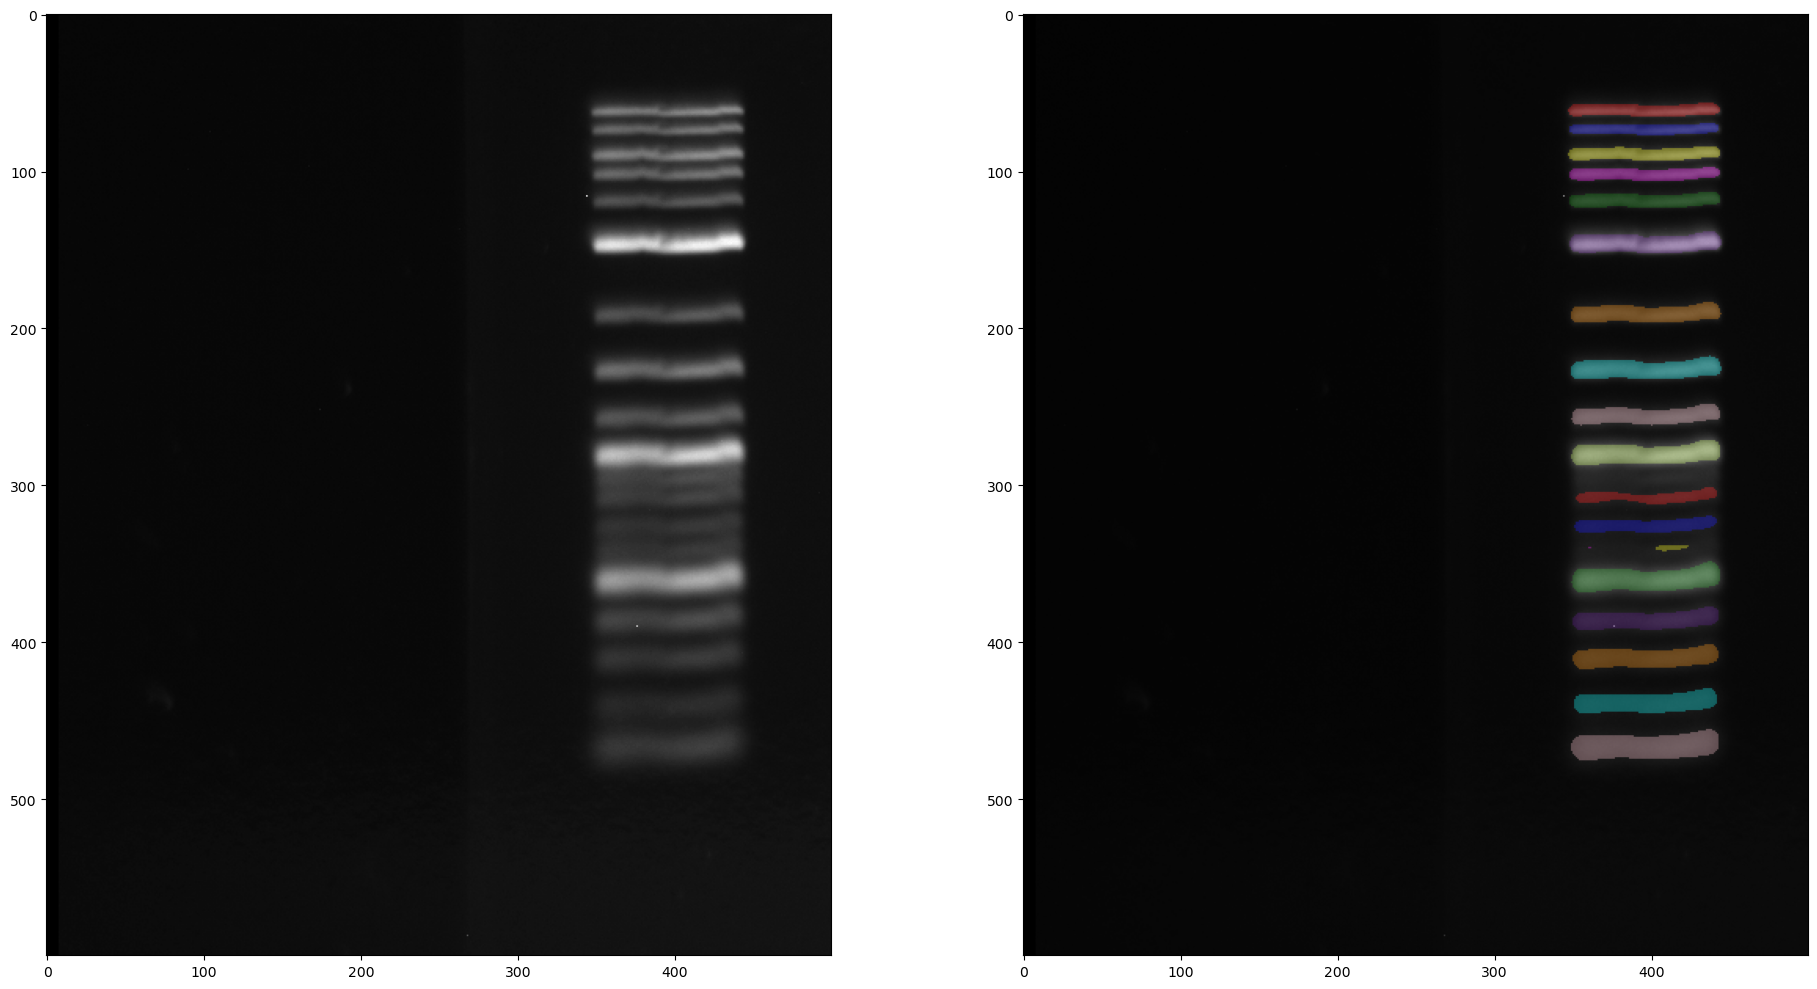

In [29]:

mask_snapshot = mask_pred[:, :, 300:900, 0:500] 
im_snapshot = size_adjusted_im[300:900, 0:500]

fig, ax = plt.subplots(1, 2, figsize=(20,10))

one_hot = F.one_hot(mask_snapshot.argmax(dim=1), 2).permute(0, 3, 1, 2).float()
segmentation_mask = one_hot.numpy().squeeze()

labeled_bands, _ = ndi.label(segmentation_mask.argmax(axis=0))

model_direct_labels = label2rgb(labeled_bands, image=im_snapshot)

ax[0].imshow(im_snapshot, cmap='gray')
ax[1].imshow(model_direct_labels)
plt.tight_layout()


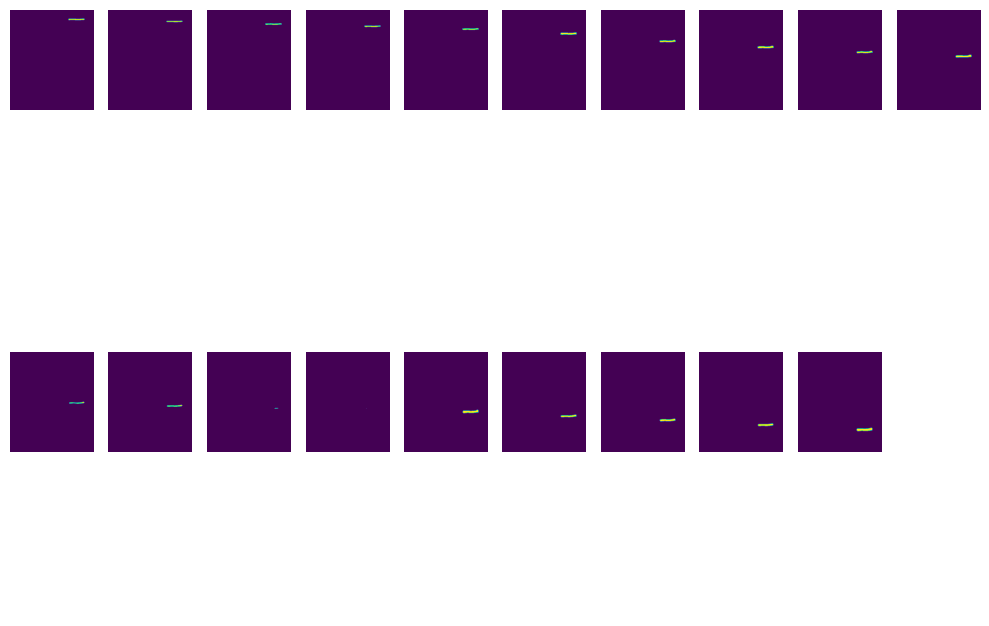

In [48]:
# checking to see if order of bands matches actual ladder order
fig,ax = plt.subplots(2,10,figsize=(10,8))

seg_intensity_sum = []

for sel_val in np.unique(labeled_bands):
    if sel_val == 0:
        continue
    
    pixel_intensities = np.sum(im_snapshot[labeled_bands==sel_val])
    seg_intensity_sum.append(pixel_intensities)
    pixel_count =  len(im_snapshot[labeled_bands==sel_val])
    combined = pixel_intensities / pixel_count  
    # combined_all.append(combined)
    # pixel_all.append(pixel_intensities)
    if sel_val == 1:
        ref_val = combined
        
    id_text = 'Band %s,\n area: %s \n pixels: %s,\n ratio: %.2f' % (sel_val, pixel_intensities, pixel_count, combined/ref_val) 
    
    new_im = np.zeros((im_snapshot.shape))
    new_im[labeled_bands==sel_val] = sel_val
    
    if sel_val > 10:
        col = 1
        sel_val -= 11
    else:
        sel_val -= 1
        col = 0

    ax[col,sel_val].imshow(new_im)
    ax[col,sel_val].axis('off')
    # ax[col,sel_val].set_title(id_text)
ax[col,9].axis('off')  
plt.tight_layout()

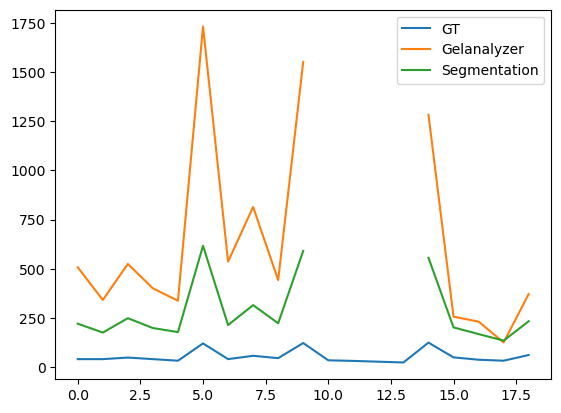

In [57]:

reference = [40, 40, 48, 40, 32, 120, 40, 57, 45, 122, 34, 31, 27, 23, 124, 49, 37, 32, 61]
gel_analyzer_results = [507, 341, 524, 400, 337, 1732, 536, 814, 442, 1552, np.nan, np.nan, np.nan, np.nan, 1283, 256, 231, 125, 371]
seg_results = [220.31766, 175.06667, 248.14511, 198.10197, 177.55685, 616.51373, 213.40785, 314.6706, 222.55687, 590.32947, np.nan, np.nan, np.nan, np.nan, 555.29803, 201.34512, 167.4863, 134.18433, 232.64316]

plt.plot(reference, label='GT')
plt.plot(gel_analyzer_results, label='Gelanalyzer')
plt.plot(seg_results, label='Segmentation')
plt.legend()
pass

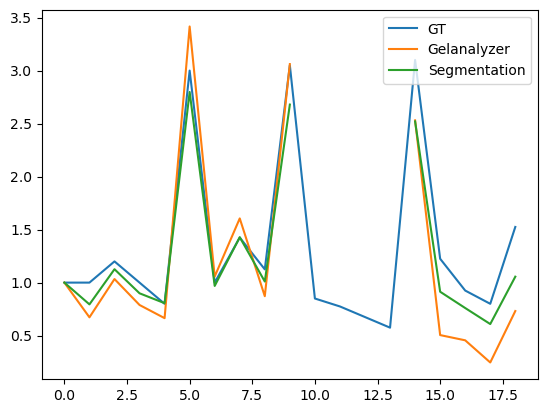

In [60]:
r_ratio = [r/reference[0] for r in reference]
g_ratio = [r/gel_analyzer_results[0] for r in gel_analyzer_results]
s_ratio =[r/seg_results[0] for r in seg_results]

plt.plot(r_ratio, label='GT')
plt.plot(g_ratio, label='Gelanalyzer')
plt.plot(s_ratio, label='Segmentation')
plt.legend()
pass

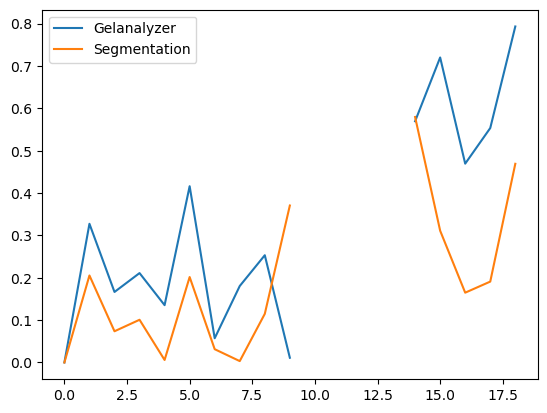

In [61]:
plt.plot([np.abs(g-r) for r,g in zip(r_ratio, g_ratio)], label='Gelanalyzer')
plt.plot([np.abs(s-r) for r,s in zip(r_ratio, s_ratio)], label='Segmentation')
plt.legend()
pass

## Overheated case

In [63]:
image_file = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/gelgenie/data_analysis/ref_data/overheated_ref.tif'

raw_im = np.array(Image.open(image_file).convert('L'))

In [72]:
# prepping model
checkpoint_file_path = "/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp_unet++_july28_1/checkpoints/checkpoint_epoch_306.pth"

net = load_model(checkpoint_file_path)

image_dir = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/gelgenie/data_analysis/ref_data'
val_set = ImageDataset(image_dir, 1, padding=True)

dataloader = DataLoader(val_set, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)

# segmentation map generation
net.eval()
for im_index, batch in enumerate(dataloader):
    with torch.no_grad():
        if batch['image_name'] == ['overheated_ref']:
            mask_pred = net(batch['image'])
            break

size_adjusted_im = batch['image'].squeeze().detach().squeeze().cpu().numpy()
        

Model loaded from /Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp_unet++_july28_1/checkpoints/checkpoint_epoch_306.pth


Padding images to 1376x1376

Created dataset with 2 images.

['ladder_reference_gel']


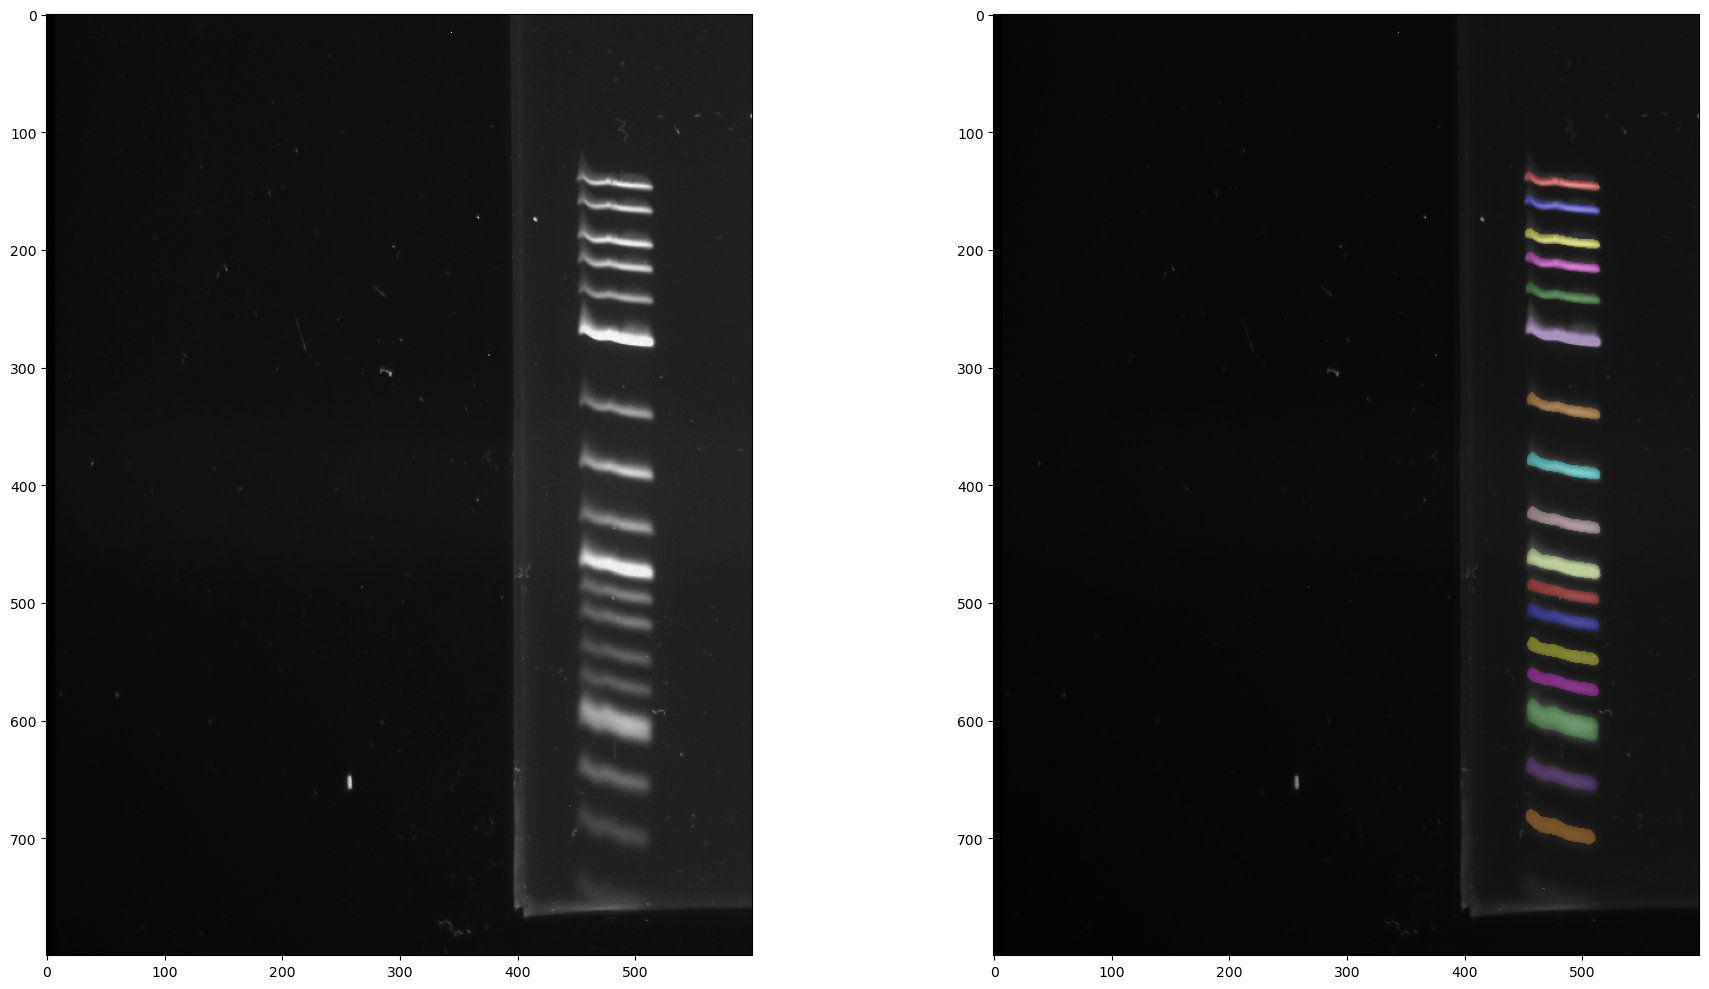

In [80]:

mask_snapshot = mask_pred[:, :, 400:1200, 0:600] 
im_snapshot = size_adjusted_im[400:1200, 0:600]

fig, ax = plt.subplots(1, 2, figsize=(20,10))

one_hot = F.one_hot(mask_snapshot.argmax(dim=1), 2).permute(0, 3, 1, 2).float()
segmentation_mask = one_hot.numpy().squeeze()

labeled_bands, _ = ndi.label(segmentation_mask.argmax(axis=0))

model_direct_labels = label2rgb(labeled_bands, image=im_snapshot)

ax[0].imshow(im_snapshot, cmap='gray')
ax[1].imshow(model_direct_labels)
plt.tight_layout()

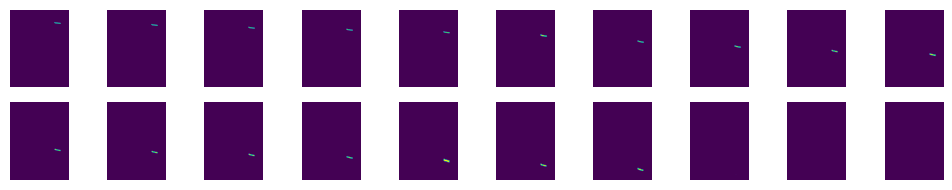

In [112]:
# checking to see if order of bands matches actual ladder order
fig,ax = plt.subplots(2,10, figsize=(10,2))

seg_intensity_sum = []

for sel_val in np.unique(labeled_bands):
    if sel_val == 0:
        continue
    
    pixel_intensities = np.sum(im_snapshot[labeled_bands==sel_val])
    seg_intensity_sum.append(pixel_intensities)
    pixel_count =  len(im_snapshot[labeled_bands==sel_val])
    combined = pixel_intensities / pixel_count  
    # combined_all.append(combined)
    # pixel_all.append(pixel_intensities)
    if sel_val == 1:
        ref_val = combined
        
    id_text = 'Band %s,\n area: %s \n pixels: %s,\n ratio: %.2f' % (sel_val, pixel_intensities, pixel_count, combined/ref_val) 
    
    new_im = np.zeros((im_snapshot.shape))
    new_im[labeled_bands==sel_val] = sel_val
    
    if sel_val > 10:
        col = 1
        sel_val -= 11
    else:
        sel_val -= 1
        col = 0

    
    ax[col,sel_val].axis('off')
    ax[col,sel_val].imshow(new_im)
    # ax[col,sel_val].set_title(id_text)
ax[col,9].axis('off')  
ax[col,8].axis('off')  
ax[col,9].imshow(np.zeros((im_snapshot.shape)))  
ax[col,8].imshow(np.zeros((im_snapshot.shape))) 
# plt.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()

pass

In [85]:
print(seg_intensity_sum)

[236.58826, 228.30197, 272.85098, 244.01178, 211.46275, 516.07056, 225.00394, 315.40393, 258.19608, 543.1373, 191.96078, 191.83138, 164.81177, 164.84706, 576.3334, 227.81961, 168.54903, 0.3647059]


In [94]:
gel_analyzer_results = [834, 707, 946, 772, 575, 1847, 716, 1119, 743, 1805, 371, 344, 292, 314, 1840, 628, 406, np.nan, np.nan]
seg_results = [236.58826, 228.30197, 272.85098, 244.01178, 211.46275, 516.07056, 225.00394, 315.40393, 258.19608, 543.1373, 191.96078, 191.83138, 164.81177, 164.84706, 576.3334, 227.81961, 168.54903, np.nan, np.nan]

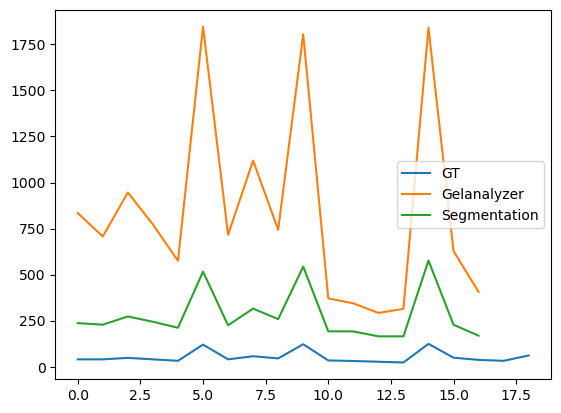

In [95]:
plt.plot(reference, label='GT')
plt.plot(gel_analyzer_results, label='Gelanalyzer')
plt.plot(seg_results, label='Segmentation')
plt.legend()
pass

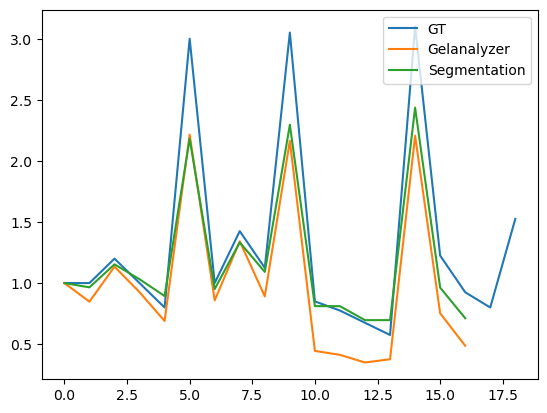

In [96]:
r_ratio = [r/reference[0] for r in reference]
g_ratio = [r/gel_analyzer_results[0] for r in gel_analyzer_results]
s_ratio =[r/seg_results[0] for r in seg_results]

plt.plot(r_ratio, label='GT')
plt.plot(g_ratio, label='Gelanalyzer')
plt.plot(s_ratio, label='Segmentation')
plt.legend()
pass

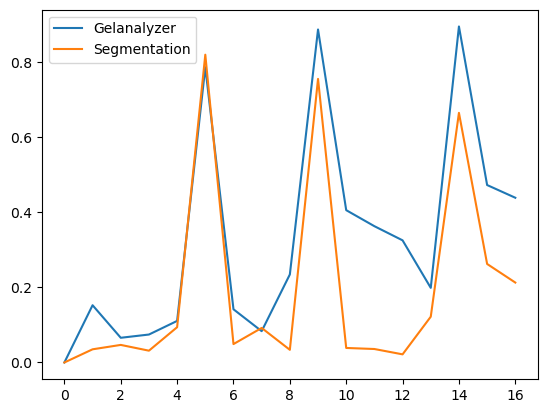

In [97]:
plt.plot([np.abs(g-r) for r,g in zip(r_ratio, g_ratio)], label='Gelanalyzer')
plt.plot([np.abs(s-r) for r,s in zip(r_ratio, s_ratio)], label='Segmentation')
plt.legend()
pass

In [90]:
len(gel_analyzer_results)

19

In [92]:
len(seg_results)

20